## Importando librerías

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, Dense, LSTM
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Lectura de datos y limpieza

In [2]:
df_15min = pd.read_csv('datos/LD2011_2014.txt', sep=';', parse_dates=[0], index_col=0, decimal=',', dtype=np.float64)
df_15min.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_15min.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


In [4]:
df_15min.shape

(140256, 370)

In [5]:
df_15min = df_15min.sort_index()
df_15min = df_15min[~df_15min.index.duplicated(keep="first")]

In [6]:
expected_freq = pd.infer_freq(df_15min.index)
print("Inferred 15-min frequency (approx):", expected_freq)

Inferred 15-min frequency (approx): 15min


In [7]:
full_idx = pd.date_range(df_15min.index.min(), df_15min.index.max(), freq=expected_freq)
if len(full_idx) != len(df_15min.index):
    print("Reindexing to full 15-min grid and forward-filling missing values...")
    df_15min = df_15min.reindex(full_idx).ffill()

In [8]:
df_daily = df_15min.resample("1D").sum()
print("Daily shape:", df_daily.shape)
df_daily.head(3)

Daily shape: (1462, 370)


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
W = 15
H = 7
# Función para crear ventanas deslizantes
def make_windows(arr, window=W, horizon=H):
    X, y = [], []
    for i in range(len(arr) - window - horizon + 1):
        X.append(arr[i:i+window])
        y.append(arr[i+window:i+window+horizon].ravel())
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

In [10]:
# Creación de los datasets X e y
X = np.empty(shape=(0,W))
y = np.empty(shape=(0,H))
n_cols = len(df_daily.columns)
for i in range(n_cols):
    arr = df_daily.iloc[:,i].values
    X_, y_ = make_windows(arr, W, H)
    X = np.concatenate([X, X_], axis=0)
    y = np.concatenate([y, y_], axis=0)

## Preparación datasets

In [11]:
# División de los datos en entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [12]:
# Estandarización de los datos
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_val = scaler_x.transform(X_val)
X_test = scaler_x.transform(X_test)
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

In [13]:
# Función para crear dataset de TensorFlow
def create_dataset(x, y, is_training=False):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  if is_training:
    dataset = dataset.shuffle(1000)
  dataset = dataset.batch(256)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

In [14]:
# Creación de datasets
train_ds = create_dataset(X_train, y_train, is_training=True)
val_ds = create_dataset(X_val, y_val)
test_ds = create_dataset(X_test, y_test)

## Creación de modelo LSTM

In [15]:
# Función para construir el modelo
def build_model(window=W, horizon=H, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal'):
    # Construcción del modelo
    model = Sequential([
        Input(shape=(window, 1)),
        LSTM(128, return_sequences=True, kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer),
        Dropout(0.2),
        LSTM(64, kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer),
        Dropout(0.2),
        Dense(horizon)
    ])
    # Compilación del modelo
    model.compile(
        optimizer=Adam(learning_rate=5e-3),
        loss="mse",
    )
    return model

In [16]:
# Modelos con con diferentes hiperparámetros de inicialización
models = []
models.append(build_model())
models.append(build_model(
    kernel_initializer='he_normal', 
    recurrent_initializer='he_normal'))
models.append(build_model(
    kernel_initializer='orthogonal', 
    recurrent_initializer='orthogonal'))
normal_dist = RandomNormal(stddev=0.2)
models.append(build_model(
    kernel_initializer=normal_dist, 
    recurrent_initializer=normal_dist))

/Users/diesn/.mdl2501/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


## Entrenamiento de modelos

In [17]:
# Callback personalizado para calcular la norma de los gradientes
class GradientNormCallback(Callback):
    def __init__(self, sample_batch):
        super().__init__()
        self.x, self.y = sample_batch

    def on_epoch_end(self, epoch, logs=None):
        # Volvemos a calcular los gradientes manualmente para este batch de referencia
        with tf.GradientTape() as tape:
            y_pred = self.model(self.x, training=True) 
            loss = self.model.compiled_loss(self.y, y_pred, regularization_losses=self.model.losses)
        # Obtenemos los gradientes de las variables entrenables
        trainable_vars = self.model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Calculamos la norma
        norm = tf.linalg.global_norm(gradients)
        # Guardamos el valor en los logs para que aparezca en 'history'
        logs['grad_norm'] = float(norm.numpy())

In [18]:
# Callbacks para el entrenamiento
sample_batch = next(iter(train_ds))
grad_callback = GradientNormCallback(sample_batch)
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True),
] + [grad_callback]

In [19]:
# Función para entrenar el modelo
def train_model(model, train_ds, val_ds, callbacks, epochs=1250):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1,
        )
    return history, model

In [20]:
# Entrenamiento de modelo y almacenamiento de datos de entrenamiento
histories = []
for i, model in enumerate(models):
    print(f"Training model {i+1}")
    history, trained_model = train_model(model, train_ds, val_ds, callbacks, epochs=1250)
    histories.append(history)
    models[i] = trained_model
    trained_model.save(f"modelos/modelo_lstm_{i+1}.keras")

Training model 1
Epoch 1/1250
1250/1250 [==============================] - 24s 19ms/step - loss: 0.0657 - val_loss: 0.0151 - grad_norm: 0.6821
Epoch 2/1250
1250/1250 [==============================] - 23s 18ms/step - loss: 0.0375 - val_loss: 0.0196 - grad_norm: 0.0928
Epoch 3/1250
1250/1250 [==============================] - 23s 19ms/step - loss: 0.0343 - val_loss: 0.0354 - grad_norm: 0.1335
Epoch 4/1250
1250/1250 [==============================] - 23s 19ms/step - loss: 0.0371 - val_loss: 0.0202 - grad_norm: 0.1890
Epoch 5/1250
1250/1250 [==============================] - 23s 19ms/step - loss: 0.0293 - val_loss: 0.0154 - grad_norm: 0.2750
Epoch 6/1250
1250/1250 [==============================] - 23s 19ms/step - loss: 0.0294 - val_loss: 0.0237 - grad_norm: 0.7038
Training model 2
Epoch 1/1250
1250/1250 [==============================] - 25s 19ms/step - loss: 0.0668 - val_loss: 0.0214 - grad_norm: 0.3108
Epoch 2/1250
1250/1250 [==============================] - 23s 19ms/step - loss: 0.03

## Visualización datos de entrenamiento

In [21]:
# Exportación de datos de entrenamiento
import pickle
with open("modelos/entrenamientos.pkl", "wb") as f:
    pickle.dump(histories, f)

In [22]:
# Carga de modelos y datos de entrenamiento guardados
models = [load_model(f"modelos/modelo_lstm_{i+1}.keras") for i in range(4)]
histories = pickle.load(open("modelos/entrenamientos.pkl", "rb"))

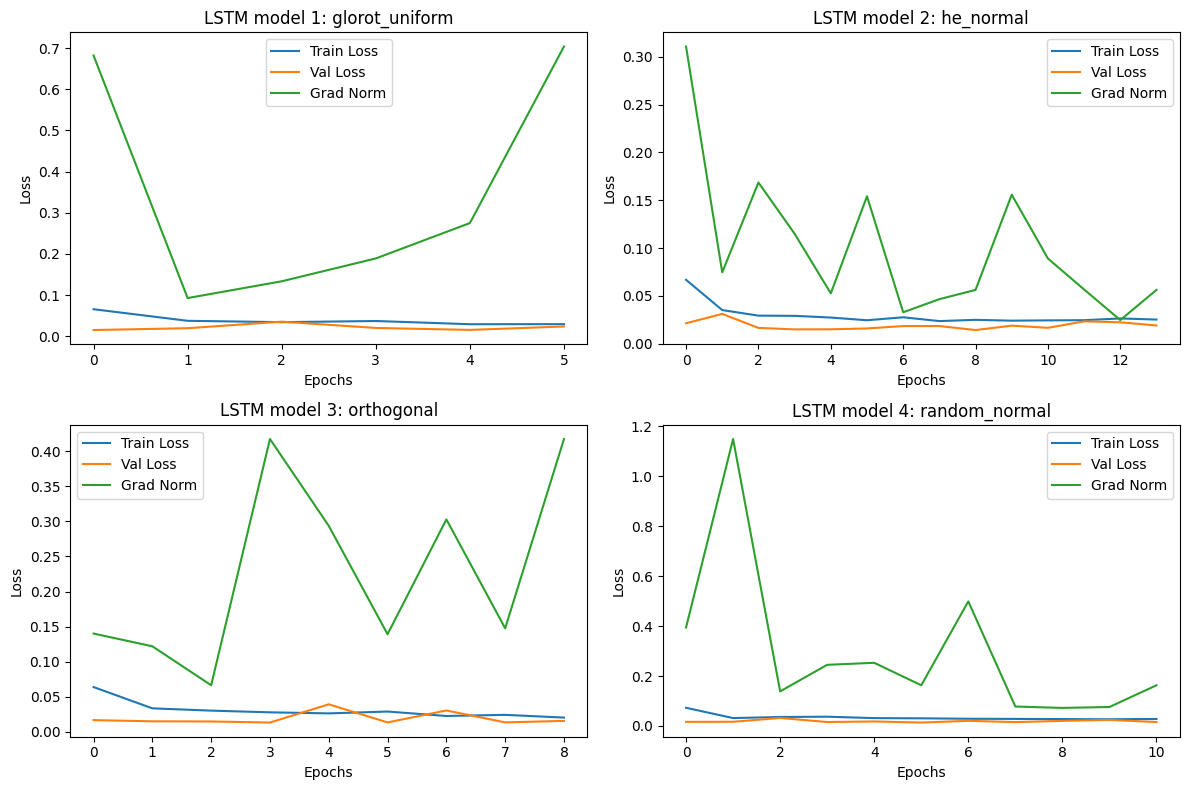

In [23]:
# Visualización de las curvas de entrenamiento y normas de gradiente
desc_models = ["glorot_uniform", "he_normal", "orthogonal", "random_normal"]
fig, axes = plt.subplots(2, 2, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    ax.plot(histories[i].history['loss'], label="Train Loss")
    ax.plot(histories[i].history['val_loss'], label="Val Loss")
    ax.plot(histories[i].history['grad_norm'], label="Grad Norm")
    ax.set_title(f"LSTM model {i+1}: {desc_models[i]}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
plt.tight_layout()
plt.show()

In [27]:
# Predicciones y evaluación del conjunto de test
y_preds = [scaler_y.inverse_transform(model.predict(test_ds)) for model in models]
y_test_inv = scaler_y.inverse_transform(y_test)

417/417 [==============================] - 3s 7ms/step


## Métricas de los modelos

In [28]:
# Cálculo y muestra de métricas de evaluación
for i, y_pred in enumerate(y_preds):
    mae = mean_absolute_error(y_test_inv, y_pred)
    mse = mean_squared_error(y_test_inv, y_pred)
    r2 = r2_score(y_test_inv, y_pred)
    print(f"Model {i+1} ({desc_models[i]}): MAE={mae:.2f}, MSE={mse:.2f}, R2={r2:.4f}")

Model 1 (glorot_uniform): MAE=6659.14, MSE=1359276155.04, R2=0.9821
Model 2 (he_normal): MAE=12116.79, MSE=1324165321.00, R2=0.9826
Model 3 (orthogonal): MAE=5107.97, MSE=1231076072.29, R2=0.9838
Model 4 (random_normal): MAE=8715.35, MSE=1231186844.96, R2=0.9838


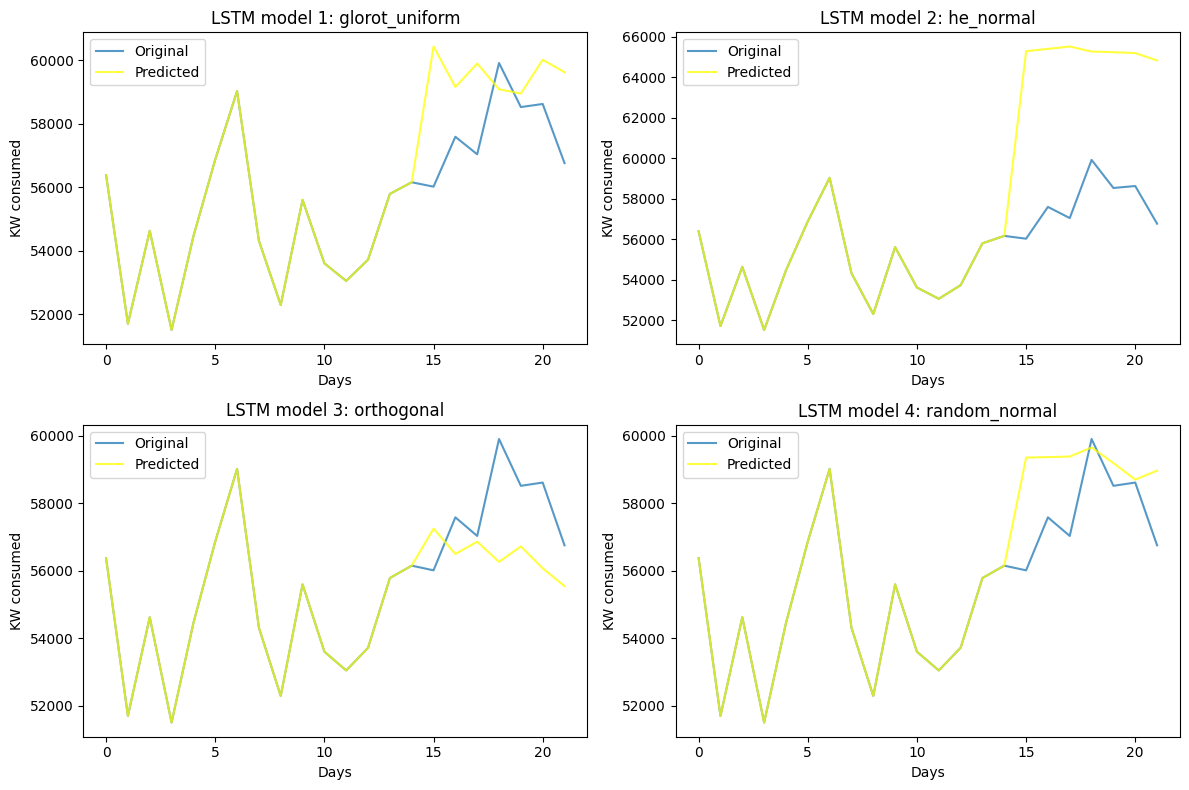

In [29]:
# Visualización de predicciones frente a valores reales
idx = 5000
past = scaler_x.inverse_transform(X_test)[idx]
future = y_test_inv[idx]
fig, axes = plt.subplots(2, 2, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    ax.plot(np.concatenate([past, future]), alpha=0.75, label="Original")
    ax.plot(np.concatenate([past, y_preds[i][idx]]), color="yellow", alpha=0.75,label="Predicted")
    ax.set_title(f"LSTM model {i+1}: {desc_models[i]}")
    ax.set_xlabel("Days")
    ax.set_ylabel("KW consumed")
    ax.legend()
plt.tight_layout()
plt.show()

En todos los modelos entrenados, ninguno sufrió de vanishing gradient descent, probablemente gracias a la inclusión de un callback de EarlyStopping y el uso de LSTMs, aún así, parece que el rendimiento de los modelos es bastante mejorable, probablemente debido a la naturaleza de los datos en si, ya que varios conjuntos de features son 0 y las variables objetivas son 0s.